# Imports

In [143]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# Read the image in grayscale and extract its key points

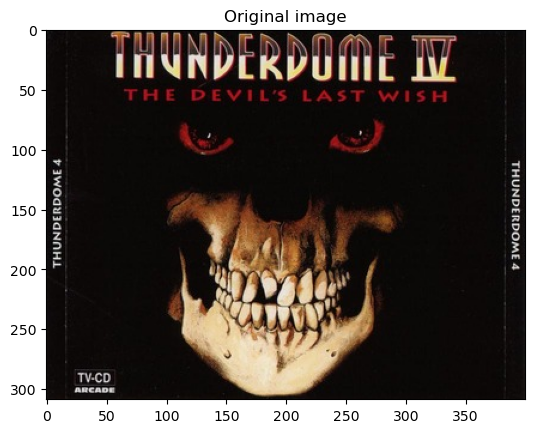

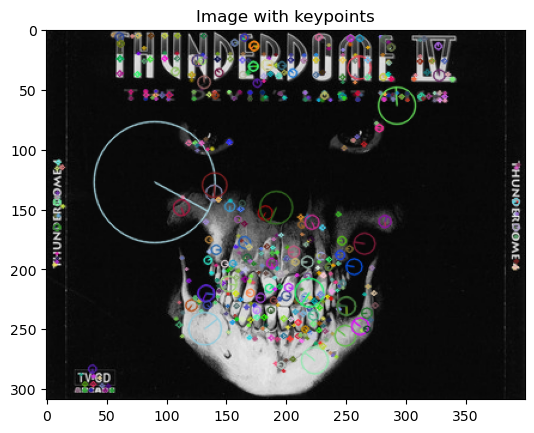

In [144]:
parent_path = './resources'
img_path = 'thunderdome.jpg'
img = cv.imread(f'{parent_path}/{img_path}')
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
sift = cv.SIFT_create()
img_kp, img_des = sift.detectAndCompute(img_gray, None)
img_with_kp = cv.drawKeypoints(img_gray, img_kp, img.copy(), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure()
plt.title('Original image')
plt.imshow(img_rgb, cmap=plt.cm.jet)
plt.figure()
plt.title('Image with keypoints')
plt.imshow(img_with_kp, cmap=plt.cm.jet)


# Modify the image and match keypoints.

## Add random noise

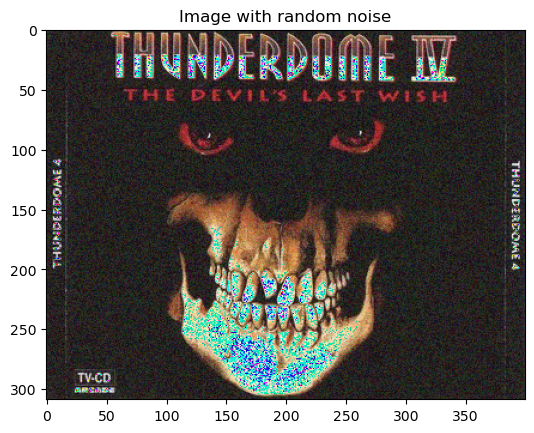

In [145]:
n, m, c = img.shape
noise = (np.random.rand(n, m, c) * 255).astype('uint8')
beta = 0.2
noisy_image = (img + beta * noise).astype('uint8')
noisy_image = ((noisy_image - noisy_image.min()) * (1/(noisy_image.max() - noisy_image.min()) * 255)).astype('uint8')
plt.title('Image with random noise')
plt.imshow(cv.cvtColor(noisy_image, cv.COLOR_BGR2RGB), cmap=plt.cm.jet)

## Apply an afine transformation to the previous noisy image

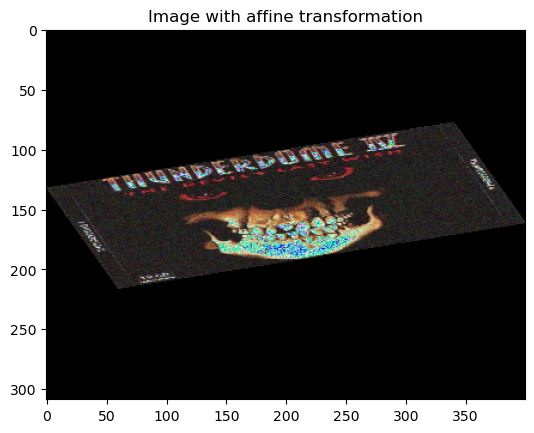

In [146]:
src = np.array([[0, 0], [noisy_image.shape[1] - 1, 0], [0, noisy_image.shape[0] - 1]]).astype(np.float32)
dst = np.array(
    [[0, noisy_image.shape[1]*0.33],
     [noisy_image.shape[1]*0.85, noisy_image.shape[0]*0.25],
     [noisy_image.shape[1]*0.15, noisy_image.shape[0]*0.7]
    ]).astype(np.float32)
warp_matrix = cv.getAffineTransform(src, dst)
img_noise_affine = cv.warpAffine(noisy_image, warp_matrix, (noisy_image.shape[1], noisy_image.shape[0]))
plt.title('Image with affine transformation')
plt.imshow(cv.cvtColor(img_noise_affine, cv.COLOR_BGR2RGB), cmap=plt.cm.jet)

## Match image descriptors

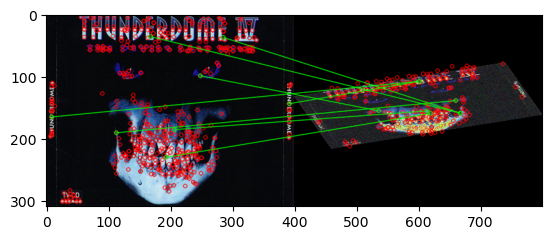

(<matplotlib.image.AxesImage at 0x167ae808a50>, None)

In [147]:
img_noise_affine_gray = img_gray = cv.cvtColor(img_noise_affine, cv.COLOR_BGR2GRAY)
img_noise_affine_kp, img_noise_affine_des = sift.detectAndCompute(img_noise_affine, None)
img_noise_affine_with_kp = cv.drawKeypoints(
    img_noise_affine_gray,
    img_noise_affine_kp,
    img_noise_affine.copy(),
    flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(img_des, img_noise_affine_des, k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7 * n.distance:
        matchesMask[i]=[1,0]
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv.DrawMatchesFlags_DEFAULT)
img3 = cv.drawMatchesKnn(img, img_kp, img_noise_affine, img_noise_affine_kp, matches, None , **draw_params)
plt.imshow(img3,),plt.show()